In [1]:
# analytics
import pandas as pd 
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
#spatial 
import osmnx as ox
import geopandas as gpd
import contextily as cx
# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#settings
import warnings

In [2]:
# suppress deprication warnings
warnings.filterwarnings('ignore') 
# plot settings
sns.set_style('darkgrid')
sns.set_palette('rocket')

# erasmus colors
rgb_1 = (0,35,40) # eur bright green
rgb_2 = (12,128,102) # eur green
rgb_3 = (227, 218, 216) #eur warm grey 
rgb_4 = (255,215,0) # ese yellow

hex_1 = '#0c8066'
hex_2 = '#002328'
hex_3 = '#e3dad8'
hex_4 = '#ffd700'
# normalize for sns and pd plotting 
rgb_1, rgb_2, rgb_3, rgb_4 = [c/255 for c in rgb_1], [c/255 for c in rgb_2], [c/255 for c in rgb_3], [c/255 for c in rgb_4]
# eur color palettes 
yellow_bright = LinearSegmentedColormap.from_list(name= 'yellow_bright',colors=[hex_4, hex_3, hex_1])
yellow_dark = LinearSegmentedColormap.from_list(name='yellow_dark', colors=[hex_4, hex_3, hex_2])
bright_dark =  LinearSegmentedColormap.from_list(name='light_dark', colors=[hex_1, hex_3, hex_2])
sequential = LinearSegmentedColormap.from_list(name='sequential', colors=[hex_3, hex_1])
discrete = LinearSegmentedColormap.from_list(name='discrete', colors=[hex_1, hex_2, hex_3, hex_4])

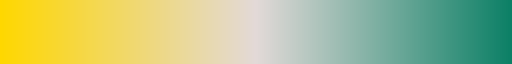

In [3]:
yellow_bright

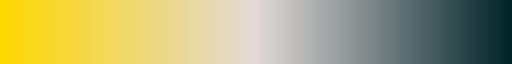

In [4]:
yellow_dark

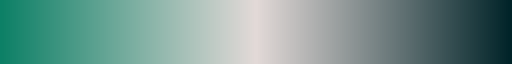

In [5]:
bright_dark

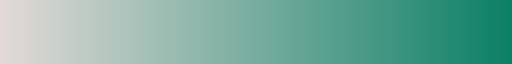

In [6]:
sequential

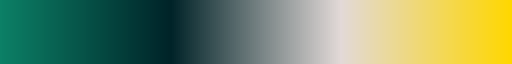

In [7]:
discrete

In [8]:
# load 2023 data set
path = '../data/2023/fema_national_household_survey_2023_data_and_codebook.xlsx'
df = pd.read_excel(path, sheet_name='Coastal Flooding', header=1)

## <span style = 'color:seagreen'> Data Cleaning <span>

<span style='color:orange'>
Let's select the important variables, rename and recode
<span>

In [9]:
variables = ['id','state','zipcode','geographic_division','census_region','county','cfld_iawareness','cfld_iperception','cfld_iexp',
             'cfld_floodzone','cfld_prepactions_a','cfld_prepactions_b','cfld_prepactions_c','cfld_prepactions_d',
             'cfld_prepactions_e','cfld_prepactions_f','cfld_prepactions_g','cfld_prepactions_h','cfld_prepactions_i',
             'cfld_prepactions_j','cfld_prepactions_k','cfld_prepactions_l','cfld_prepactions_m','cfld_prepactions_n',
             'age','sex','education','race_selfid','homeownership','income','rentmortgage', 'rurality','hazard_weight']
df = df[variables]

In [10]:
# Let's rename some variables
df = df.rename(columns= {
    'cfld_prepactions_a': 'supplies',
    'cfld_prepactions_b': 'insured',
    'cfld_prepactions_c': 'involved',
    'cfld_prepactions_d': 'learned_routes',
    'cfld_prepactions_e': 'made_plan',
    'cfld_prepactions_f': 'made_safer',
    'cfld_prepactions_g': 'planned_neighbors',
    'cfld_prepactions_h': 'practiced_drills',
    'cfld_prepactions_i': 'documents',
    'cfld_prepactions_j': 'rainy_day',
    'cfld_prepactions_k': 'alerts',
    'cfld_prepactions_l': 'family_communication',
    'cfld_prepactions_m': 'none',
    'cfld_prepactions_n': 'dont_know',
    'cfld_iawareness': 'awareness',
    'cfld_iperception': 'perception',
    'cfld_iexp': 'experience',
    'cfld_floodzone': 'floodzone',
    'race_selfid': 'race'
})

In [11]:
df.head()

,id,state,zipcode,geographic_division,census_region,county,awareness,perception,experience,floodzone,...,dont_know,age,sex,education,race,homeownership,income,rentmortgage,rurality,hazard_weight
0,1,Washington,98033,Pacific,West,King,No,Yes,No,No,...,Blank,20-29,Male,Bachelor's degree,White,Own,"$75,000 to $99,999","$1,001 - $1,500",Urban,0.255097
1,2,Florida,33950,South Atlantic,South,Charlotte,Yes,Yes,Yes,Yes,...,Blank,50-59,Female,Post graduate work/degree or professional degree,White,Own,"$150,000 to $199,999","More than $3,000",Urban,2.836145
2,3,New Jersey,7031,Middle Atlantic,Northeast,Bergen,No,Yes,Yes,No,...,Blank,30-39,Female,High school degree or diploma,White,Rent,"$35,000 to $49,999","$1,001 - $1,500",Urban,1.165971
3,4,Pennsylvania,19115,Middle Atlantic,Northeast,Philadelphia,Unknown,Unknown,Unknown,No,...,Don't know,40-49,Female,High school degree or diploma,White,Rent,"$50,000 to $74,999",Don't know,Urban,0.794098
4,5,Pennsylvania,19148,Middle Atlantic,Northeast,Philadelphia,No,Yes,Yes,No,...,Blank,30-39,Male,Bachelor's degree,White,Own,"$100,000 to $149,999","$1,001 - $1,500",Urban,0.624890


<span style='color:orange'>
Let's have a first look at the data 
<span>

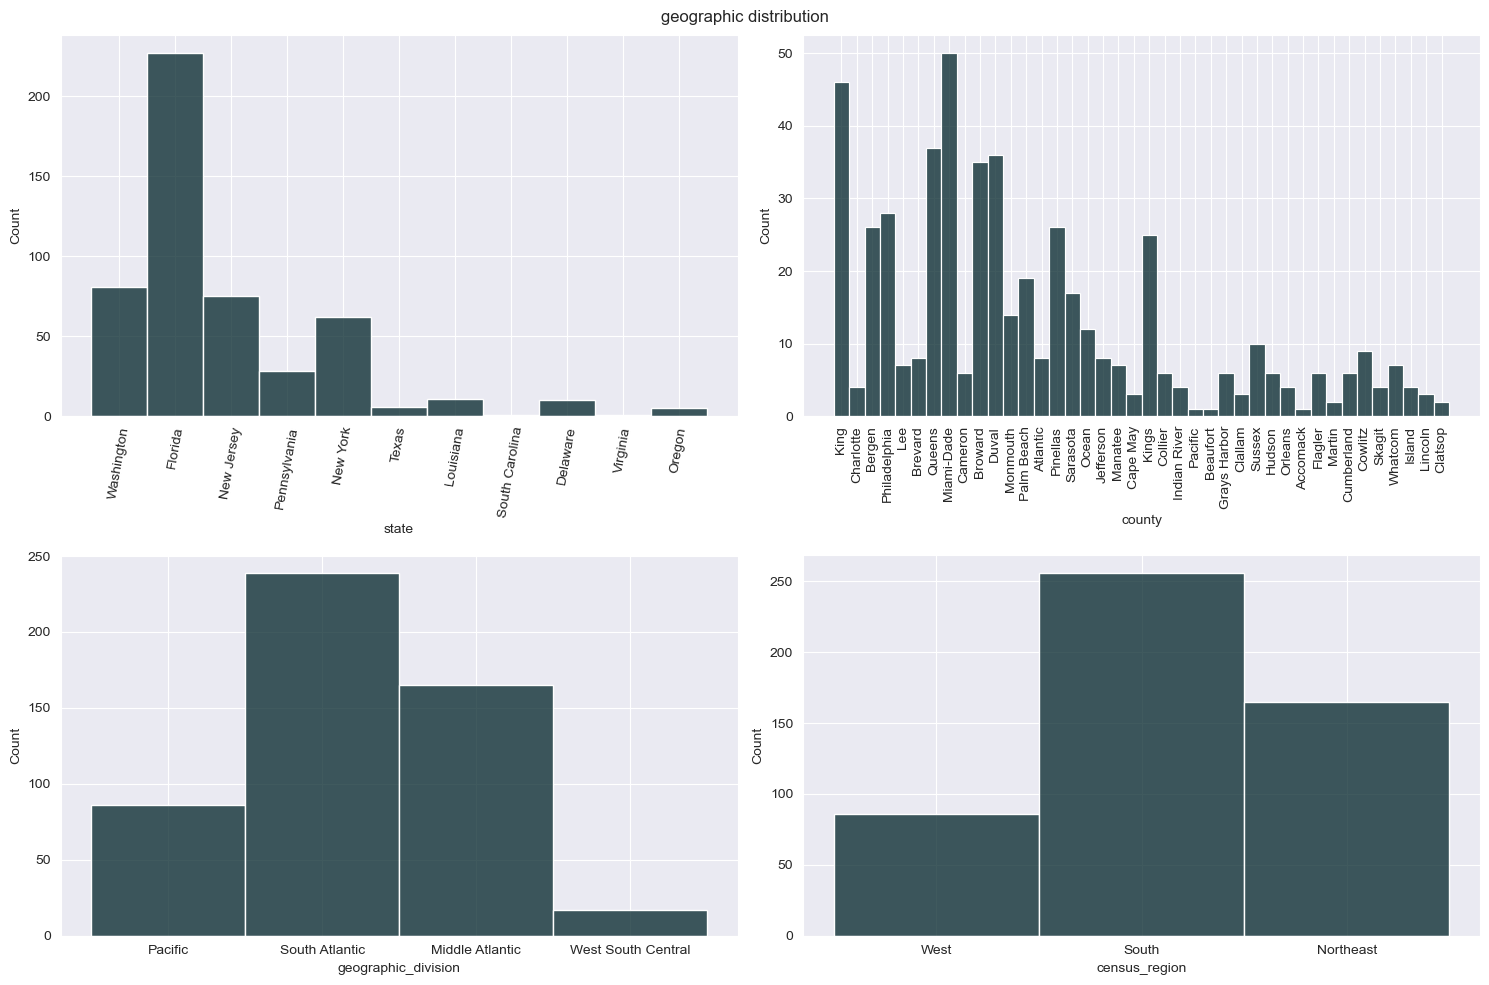

In [12]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

sns.histplot(df.state, ax = ax[0,0], color=rgb_1)
sns.histplot(df.county, ax = ax[0,1], color=rgb_1)
sns.histplot(df.geographic_division, ax = ax[1,0], color=rgb_1)
sns.histplot(df.census_region, ax = ax[1,1], color=rgb_1)

#adjust individual x label rotations for readability
ax[0,0].tick_params(axis='x', rotation = 80)
ax[0,1].tick_params(axis='x', rotation=90)
plt.suptitle('geographic distribution')
plt.tight_layout() 

<span style="color:lightgreen">
findings: 

- only respondents in flood regions are included

- most respondents from florida 
- pacific underrepresnted compared to atlantic
<span>




<span style="color:orange">
to understand spatial distribution of respondents (and other variables, we will have to add shapefiles)

let's look into response variables first
<span>

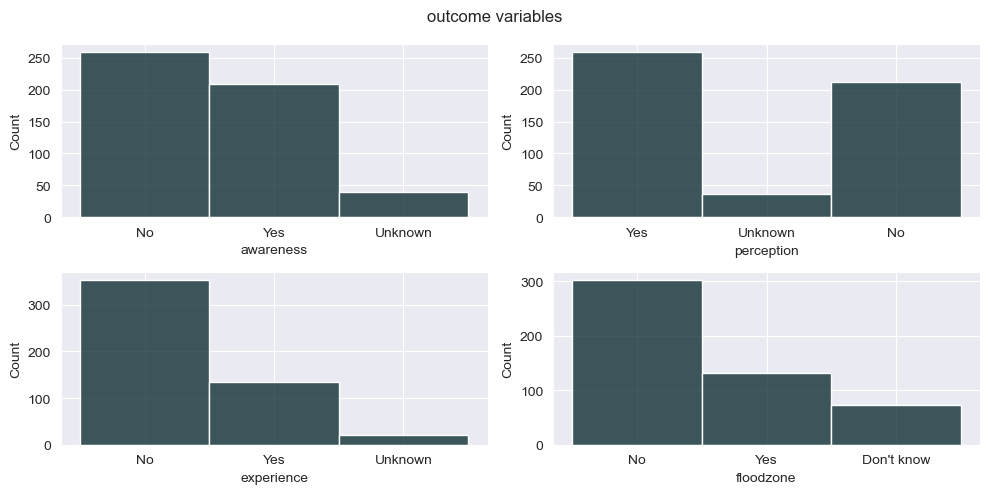

In [13]:
fig, ax = plt.subplots(2,2, figsize=(10,5))

sns.histplot(df.awareness, ax = ax[0,0], color=rgb_1)
sns.histplot(df.perception, ax = ax[0,1], color=rgb_1)
sns.histplot(df.experience, ax = ax[1,0], color=rgb_1)
sns.histplot(df.floodzone, ax = ax[1,1], color=rgb_1)

plt.suptitle('outcome variables')
plt.tight_layout() # avoid overlap of labels

<span style='color:lightgreen'>
findings: 

- ca 60% respondents do not live in a flood zone. That can in part be bc not every flood area is mapped by FEMA yet
- ca 20% has experienced flood before
- cfld_perception gives rich data distribution

- don't know is a small number. Can we maybe leave them out? 

<span style= 'color:orange'>
Let's change the variable coding and dtypes to numeric
<span>

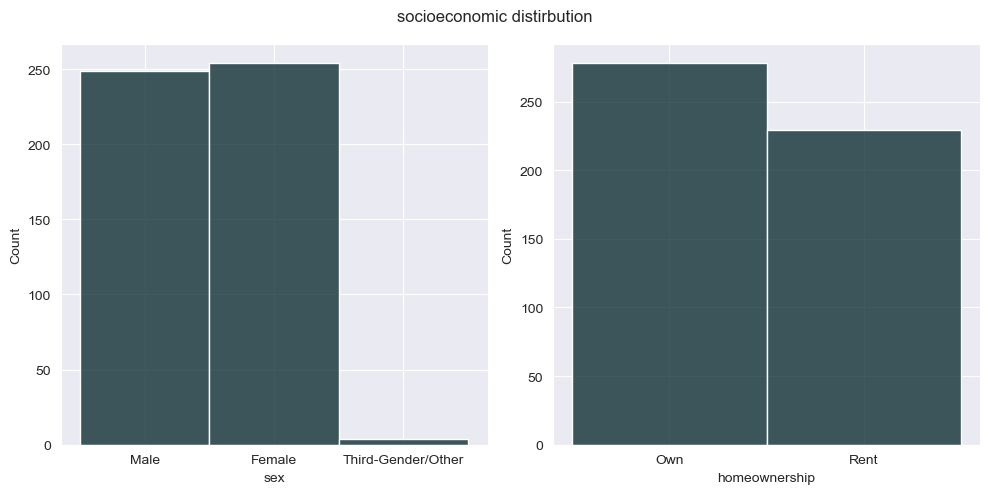

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.histplot(df.sex, ax = ax[0], color=rgb_1)
sns.histplot(df.homeownership, ax = ax[1], color=rgb_1)

plt.suptitle('socioeconomic distirbution')
plt.tight_layout() # avoid overlap of labels

In [15]:
df.sex.replace({"Male":0, "Female":1, 'Third-Gender/Other': np.nan}, inplace = True)
df.homeownership.replace({'Rent':0, 'Own':1}, inplace = True)
df.rurality.replace({'Urban': 1, 'Rural': 0}, inplace=True)

In [16]:
variables = ['perception', 'awareness', 'experience', 'floodzone']
dict = {
   'No': 0,
   'Yes': 1,
   'Unknown': np.nan,
   "Don't know": np.nan 
}
df[variables] = df[variables].replace(dict)

In [17]:
dict = {'Less than $10,000':10000,
        '$10,000 to $14,999':12500,
        '$15,000 to $24,999':20000,
        '$25,000 to $34,999':30000,
        '$35,000 to $49,999':47500,
        '$50,000 to $74,999':62500,
        '$75,000 to $99,999':87500,
        '$100,000 to $149,999':125000,
        '$150,000 to $199,999':175000,
        '$200,000 or more':290000
        }
df.income.replace(dict, inplace = True);

value for highest income bracket is representing median income in that bracket:

https://www.census.gov/programs-surveys/cps.html

https://www.census.gov/library/publications/2022/demo/p60-276.html

In [18]:
dict = {'18-19': 18.5,
        '20-29': 25,
        '30-39': 35,
        '40-49': 45,
        '50-59': 55,
        '60-69': 65,
        '70-79': 75,
        '80+': 90
}
df.age.replace(dict, inplace = True);

In [19]:
dict={'Less than high school diploma':0,
      'High school degree or diploma':1,
      'Some college, no degree':2,
      "Associate's degree":3, 
      "Bachelor's degree":4, 
      'Post graduate work/degree or professional degree':5
      }
df.education.replace(dict, inplace = True)

In [20]:
dict={'$0' : 0,
      '$1 - $500':250,
      '$501 - $750':675,
      '$751 - $1,000':875,
      '$1,001 - $1,500':1250,
      '$1,501 - $2,000':1750,
      '$2,001 - $2,500':2250,
      '$2,501 - $3,000':2750,
      'More than $3,000':3000,
      "Don't know": np.nan
      }
df.rentmortgage.replace(dict, inplace = True)

In [21]:
df.supplies.replace({'Blank': 0, 'Assembled or updated supplies': 1}, inplace=True)
df.insured.replace({'Blank': 0, 'Documented and insured property': 1}, inplace=True)
df.involved.replace({'Blank': 0, 'Got involved in my community': 1}, inplace=True)
df.learned_routes.replace({'Blank': 0, 'Learned my evacuation routes': 1}, inplace=True)
df.made_plan.replace({'Blank': 0, 'Made a plan': 1}, inplace=True)
df.made_safer.replace({'Blank': 0, 'Made my home safer': 1}, inplace=True)
df.planned_neighbors.replace({'Blank': 0, 'Planned with neighbors': 1}, inplace=True)
df.practiced_drills.replace({'Blank': 0, 'Practiced emergency drills or habits': 1}, inplace=True)
df.documents.replace({'Blank': 0, 'Safeguarded documents': 1}, inplace=True)
df.rainy_day.replace({'Blank': 0, 'Saved for a rainy day': 1}, inplace=True)
df.alerts.replace({'Blank': 0, 'Signed up for alerts and warnings': 1}, inplace=True)
df.family_communication.replace({'Blank': 0, 'Tested family communication plan': 1}, inplace=True)
df.none.replace({'Blank': 0, 'None of the above': 1}, inplace=True)
df.dont_know.replace({'Blank': 0, "Don't know": 1}, inplace=True)

# let's also code as integer
variables = ['supplies','insured', 'involved', 'learned_routes', 'made_plan', 
             'made_safer', 'planned_neighbors', 'practiced_drills', 'documents', 
             'rainy_day', 'alerts','family_communication', 'none', 'dont_know']
df[variables] = df[variables].astype(int)

In [22]:
# lets recode zipcodes as string and fill up leading zeros that have gone missing 
df.zipcode = df.zipcode.astype('string')

for i in df.index: 
    if len(df.at[i,'zipcode']) == 4: 
        df.at[i,'zipcode'] = str(0) + df.at[i,'zipcode']
    if len(df.at[i,'zipcode']) <= 4:
        print(i)
# classic lets try shit and pray loop... Make sure we fetched all exceptions...

In [23]:
df.loc[:, df.isna().any()].isna().mean()

awareness       0.076923
perception      0.071006
experience      0.039448
floodzone       0.143984
sex             0.007890
rentmortgage    0.029586
dtype: float64

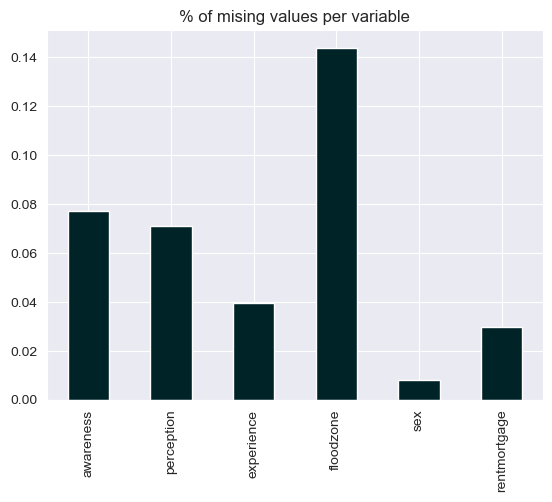

In [24]:
# let's see how many variables we have lost due to np.nan coding
df.loc[:, df.isna().any()].isna().mean().plot(kind='bar', title='% of mising values per variable', color=rgb_1);

In [25]:
df = df.drop(columns=['floodzone','awareness','perception'])

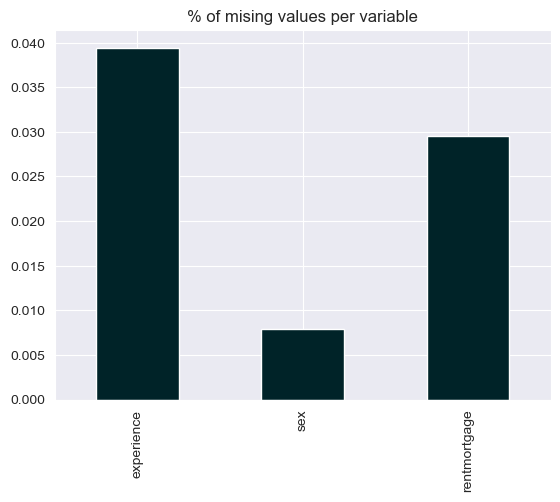

In [26]:
df.loc[:, df.isna().any()].isna().mean().plot(kind='bar', title='% of mising values per variable', color=rgb_1);

### Double check this code block above!

In [27]:
df.dropna(inplace=True) 

In [28]:
df.shape 

(472, 30)

## <span style='color:seagreen'> Exploratory Analysis <span>

<span style='color:orange'>
Let's have a look at socioeconomic distributions

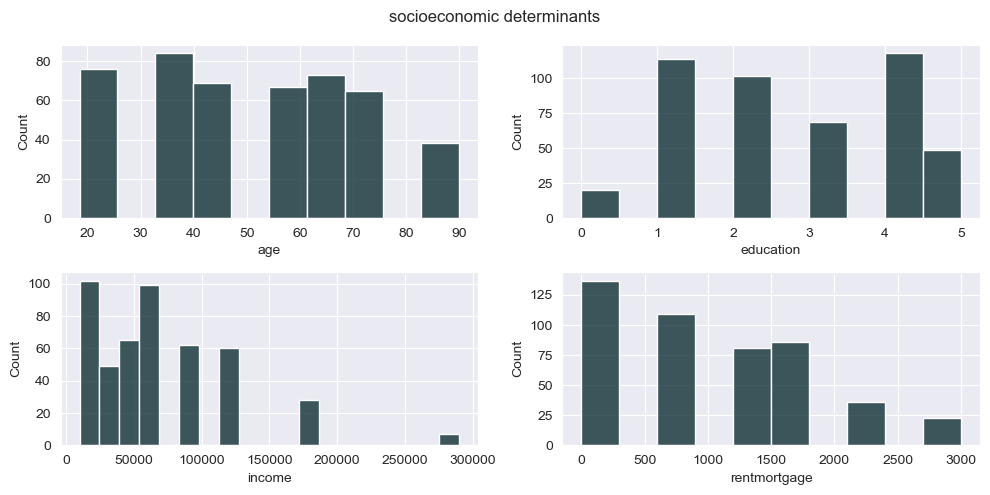

In [29]:
fig, ax = plt.subplots(2,2, figsize=(10,5))

sns.histplot(df.age, ax = ax[0,0], color=rgb_1)
sns.histplot(df.education, ax = ax[0,1], color=rgb_1)
sns.histplot(df.income, ax = ax[1,0], color=rgb_1)
sns.histplot(df.rentmortgage, ax = ax[1,1], color=rgb_1)

plt.suptitle('socioeconomic determinants')
plt.tight_layout() # avoid overlap of labels
plt.savefig('../figures/unimodal/socioeconoimc_determinants.png', dpi=1000)

<span style='color:orange'>
Let's have a look at adaptation measures

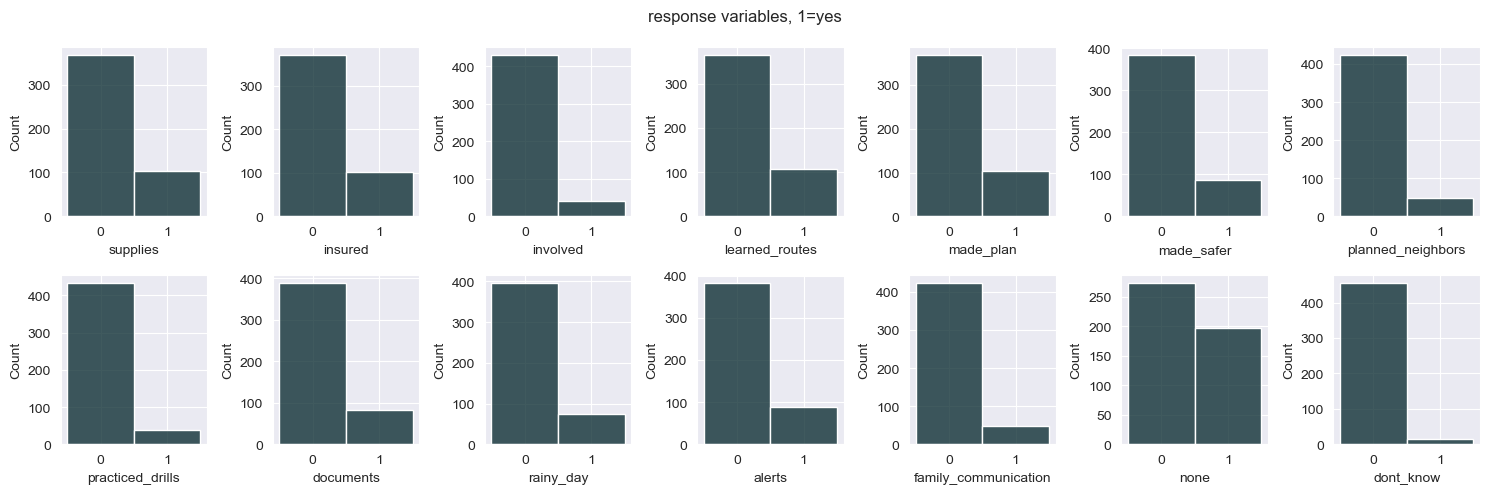

In [30]:
fig, ax = plt.subplots(2,7, figsize=(15,5))
ax = ax.flatten()
for idx, var in enumerate(variables): 
    sns.histplot(df[var], ax = ax[idx], discrete=True, color=rgb_1)
plt.suptitle('response variables, 1=yes')
plt.tight_layout()
plt.savefig('../figures/unimodal/response_distribution_n.png')

<span style = 'color: lightgreen'>
findings: 

- 40% of respondents have implemented nothing

- almost all adaptation options are implemented equally often. 
<span>


<span style = 'color: orange'>
Let's look at some correlations
<span>


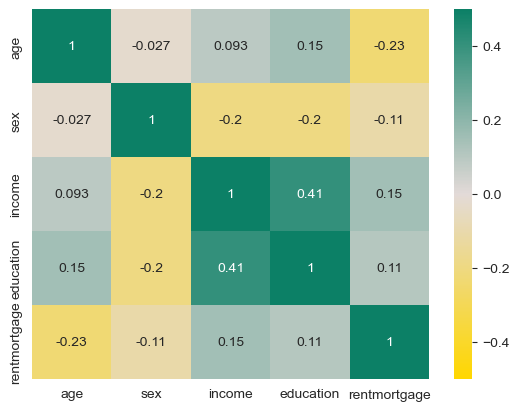

In [31]:
variables = ['age', 'sex', 'income', 'education', 'rentmortgage']
spearman = pd.DataFrame(
    data = stats.spearmanr(df[variables])[0],
    index = variables,
    columns = variables
)
sns.heatmap(spearman, cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot = True)
plt.savefig('../figures/relations/socioeconomic_n.png', bbox_inches='tight', dpi=1000)

<span style= 'color:lightgreen'>
findings: 

- correlation among covariates are small 

- notably, low correlation between age and income

- note relation between (education, rentmortgage) and age

- variables are nominal, correlation mathematically incorrect. 

<span style= 'color:orange'>
Let's map relationships between covariates and responses


In [32]:
variables = ['experience']
index = ['age', 'sex', 'income', 'rentmortgage', 'education']
age = [np.corrcoef(df.age, df[var])[0,1] for var in variables]
sex = [np.corrcoef(df.sex, df[var])[0,1] for var in variables]
income = [np.corrcoef(df.income, df[var])[0,1] for var in variables]
rentmortgage = [np.corrcoef(df.rentmortgage, df[var])[0,1] for var in variables]
education = [np.corrcoef(df.education, df[var])[0,1] for var in variables]

cor_df = pd.DataFrame([age, sex, income, rentmortgage, education] , index = index, columns = variables)
cor_df

,experience
age,-0.168184
sex,0.011309
income,-0.012016
rentmortgage,0.145276
education,-0.015856


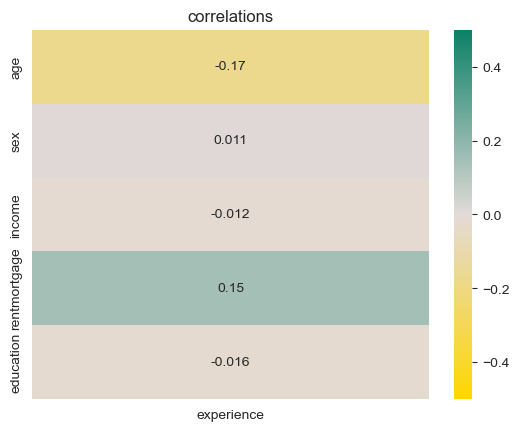

In [33]:
fig, ax = plt.subplots()
fig = sns.heatmap(cor_df, cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True)
plt.title('correlations')
plt.savefig('../figures/relations/determinants_n.png', dpi=1000)

<span style='color:lightgreen'>
findings: 

- older respondents are expecting less flooding
- older respondents are less likely to have experienced floodings??? 

<span style = 'color:orange'>
Let's have a look at correlations between outcome variables
<span>

<Axes: >

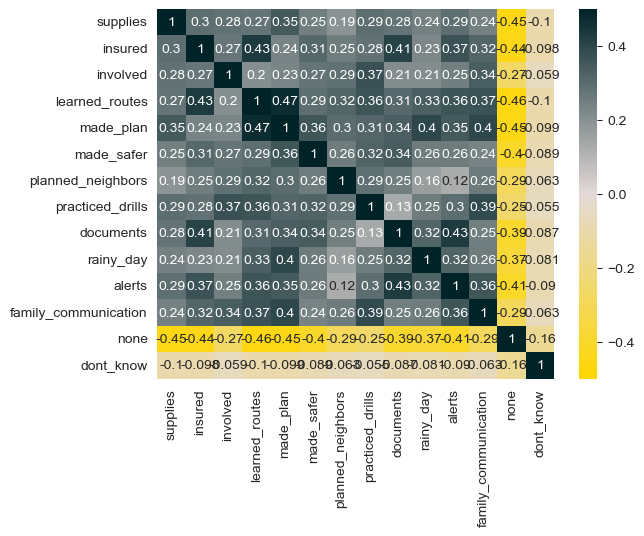

In [34]:
variables = ['supplies', 'insured', 'involved', 'learned_routes', 'made_plan',
             'made_safer', 'planned_neighbors', 'practiced_drills', 'documents', 'rainy_day',
             'alerts', 'family_communication', 'none', 'dont_know']
sns.heatmap(df[variables].corr(),cmap=yellow_dark, vmin=-0.5, vmax=0.5, annot=True)

<span style= 'color:lightgreen'>
findings: 

- all of the above correlate in same range: no specific links between specific types of adaptation 
- learned_routs and insured correlate stronger
- documents and insured correlate stronger
- alerts and insured correlate stronger
- made_plan and learned_routes correlate stronger

- alerts and documents correlate stronger

## <span style='color:seagreen'>Spatial Mapping<span>

In [35]:
path = "/Users/philip/Documents/ESE/ESE_thesis/flood_experience/data/shapefiles/tl_2024_us_zcta520.shp"

shp_gdf = gpd.read_file(path)
shp_gdf = shp_gdf.drop(columns=['ZCTA5CE20','GEOIDFQ20','CLASSFP20','MTFCC20','FUNCSTAT20','ALAND20','AWATER20','INTPTLAT20','INTPTLON20'])

In [36]:
# lets merge it baby
shp_gdf= shp_gdf.rename(columns={'GEOID20':'zipcode'})
gdf = df.merge(shp_gdf, on = 'zipcode', how = 'left')
gdf = gpd.GeoDataFrame(gdf, geometry = gdf.geometry)

In [37]:
# adjust crs to cx requirements (Web Mercator)
gdf = gdf.to_crs(epsg=3857)  
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
gdf.shape

(472, 31)

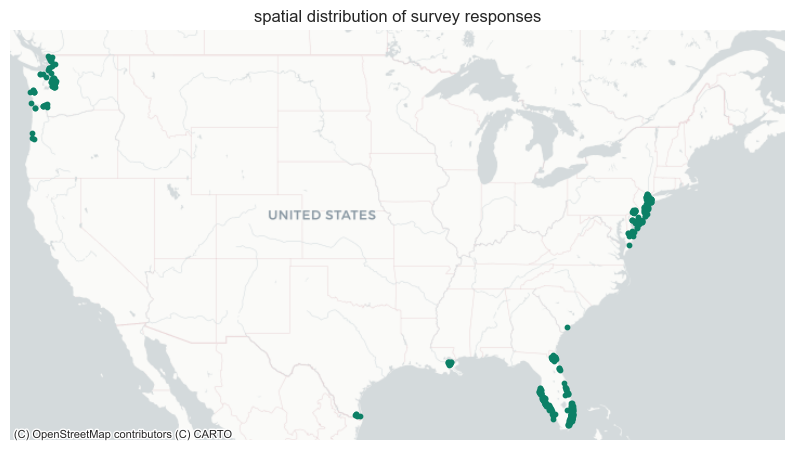

In [39]:

us_bounds = (-14000000, 2800000, -7000000, 6500000)  

# Let's switch to point geometries so that we can increase the marker size manually
gdf_points = gdf.copy()
gdf_points['geometry'] = gdf_points.centroid

fig, ax = plt.subplots(figsize=(10,10))
gdf_points.plot(ax=ax, color=rgb_2, alpha=1, markersize=10)
ax.set_xlim(us_bounds[0], us_bounds[2])  # Longitude limits
ax.set_ylim(us_bounds[1], us_bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title('spatial distribution of survey responses')
plt.savefig('../figures/spatial/us_map.png', dpi=1000)

<span style= 'color:lightgreen'>
findings: 

- Many flood regions (California & mid-East Coast) have no responses in the 2023 data

- focus regions will be washington/ oregon, florida, new jersey/ pennsylvania/ delaware/ virginia


<span style= 'color:orange'>
to do: 

- check response distribution against other years

In [40]:
# Let's add a column to our dataframe that counts total occurence of zipcodes 
zip_counts = df.groupby(by='zipcode').size()
zip_counts = pd.DataFrame(zip_counts, columns=['zip_count'])
gdf = gdf.merge(zip_counts, on = 'zipcode', how='left')

In [41]:
# export the data
path = '/Users/philip/Documents/ESE/ESE_thesis/flood_experience/data/export/clean_n.csv'
gdf.to_csv(path, index=False)

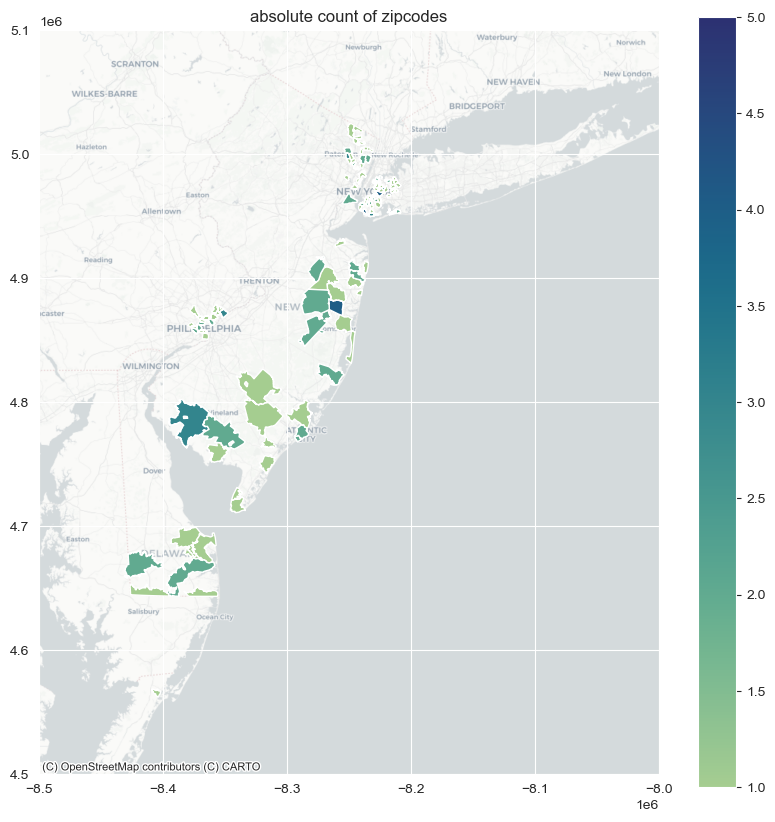

In [42]:
# new jersey
bounds = (-8500000, 4500000, -8000000, 5100000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, cmap='crest', alpha=1, column='zip_count', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('../figures/spatial/density/newjersey_zips_density.png', dpi=1000)

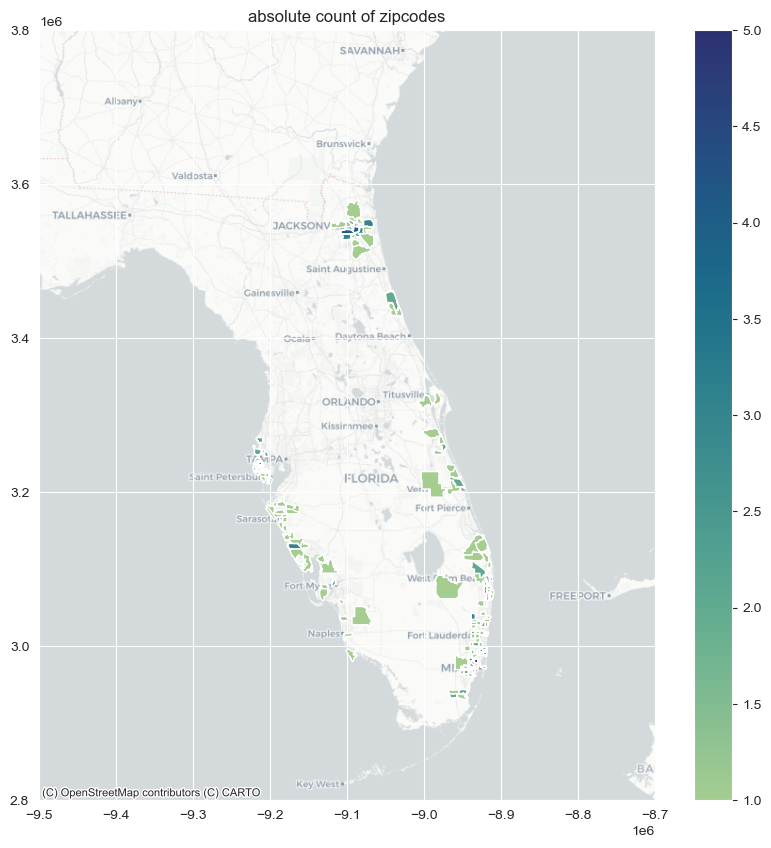

In [43]:
# florida
bounds = (-9500000, 2800000,  -8700000, 3800000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, cmap='crest', alpha=1, column='zip_count', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('../figures/spatial/density/florida_zips_density.png', dpi=1000)

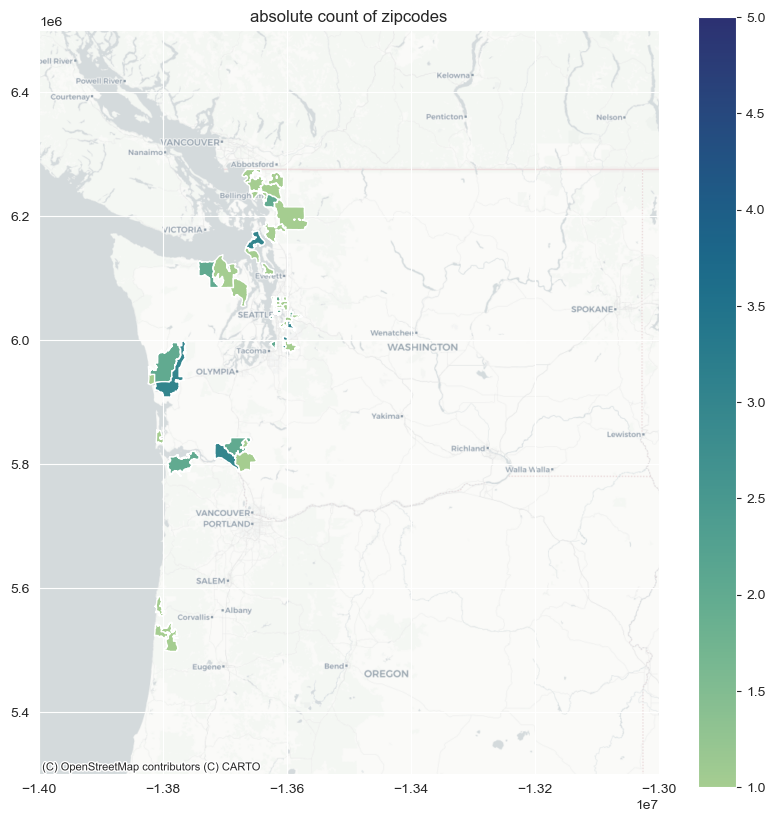

In [44]:
# seattle
bounds = (-14000000, 5300000, -13000000, 6500000)

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, cmap='crest', alpha=1, column='zip_count', legend=True)
ax.set_xlim(bounds[0], bounds[2])  # Longitude limits
ax.set_ylim(bounds[1], bounds[3])  # Latitude limits
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title('absolute count of zipcodes')
plt.savefig('../figures/spatial/density/seattle_zips_density.png', dpi=1000)

<span style='color:lightgreen'>
Findings:

- highest count of repsonses in one zipcode is 5

- overall, response rate spread very thin across space, very evenly

- most responses are in florida (see above too) but are evenly dispersed in space  

- spatial interaction might be hard to fetch with such low data density
- LISA plots / spatial autocorrelation not making sense anymore?

<span style='color:orange'>
Let's search for seperating equilibria next 

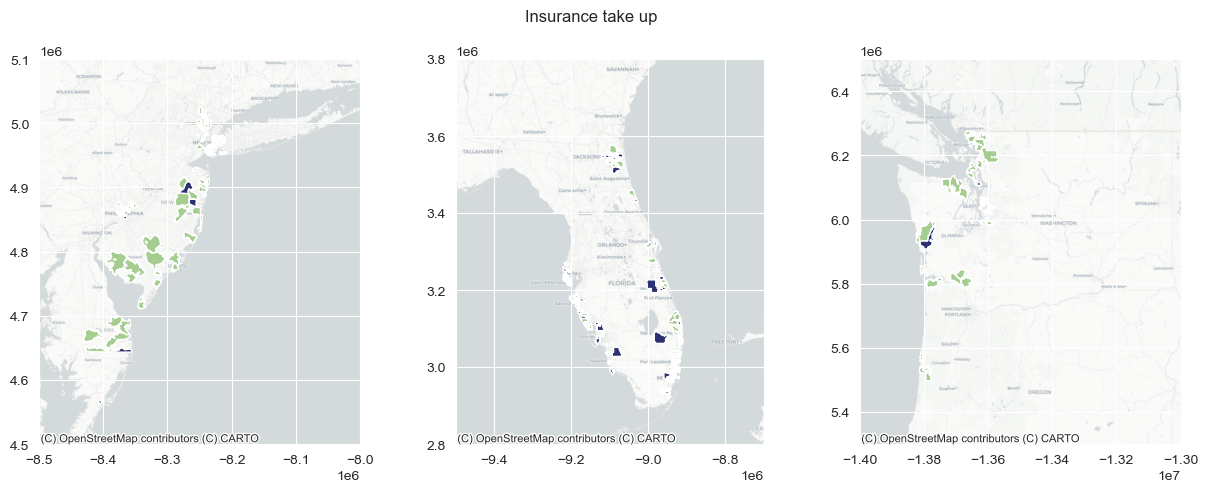

In [45]:
# let's plot insurance takeup

bounds = [(-8500000, 4500000, -8000000, 5100000),       #new jersey
          (-9500000, 2800000,  -8700000, 3800000),      #florida
          (-14000000, 5300000, -13000000, 6500000)]     #seattle

fig, ax = plt.subplots(1,3, figsize=(15,5))

for idx, var in enumerate(bounds):    
    gdf.plot(ax=ax[idx], cmap='crest', column='insured', categorical=True)
    ax[idx].set_xlim(bounds[idx][0], bounds[idx][2])
    ax[idx].set_ylim(bounds[idx][1], bounds[idx][3])
    cx.add_basemap(ax[idx], source=cx.providers.CartoDB.Positron)

plt.suptitle('Insurance take up')
plt.savefig('../figures/spatial/density/insurance.png', dpi=1000)

<span style='color:lightgreen'>
findings: 

- insurance take up is much more pronounced in florida, compared to seattle and new jersey

- first hint at pooling equilibrium 

- lets see if there are counfounding factors? 

See prints: 3by3 plot

<span style = 'color:lightgreen'>
findings: 

- experience seems to correlate with insurance take up 

- when you know that you are in a flood zone, you are more likely linsured in new jersey and florida, but not in seattle! 

- in seattle people are having higher perception but no experience -> no insurance take up

- in florida we have high perception, high experience, and high take up

<span style='color:orange'>
Let's confirm difference in share of adaptaion outcomes

In [46]:
adaptations = gdf.groupby('state').agg(
    supplies = ('supplies','mean'),
    insurance = ('insured','mean'),
    involved = ('involved','mean'),
    learned_routes = ('learned_routes','mean'),
    made_plan =  ('made_plan', 'mean'),
    made_safer = ('made_safer', 'mean'),
    planned_neighbors = ('planned_neighbors', 'mean'),
    practiced_drills = ('practiced_drills', 'mean'),
    documents = ('documents', 'mean'),
    rainy_day = ('rainy_day', 'mean'),
    alerts = ('alerts', 'mean'),
    family_communication = ('family_communication', 'mean'),
    none = ('none', 'mean'),
    dont_know = ('dont_know', 'mean')
    ).transpose()

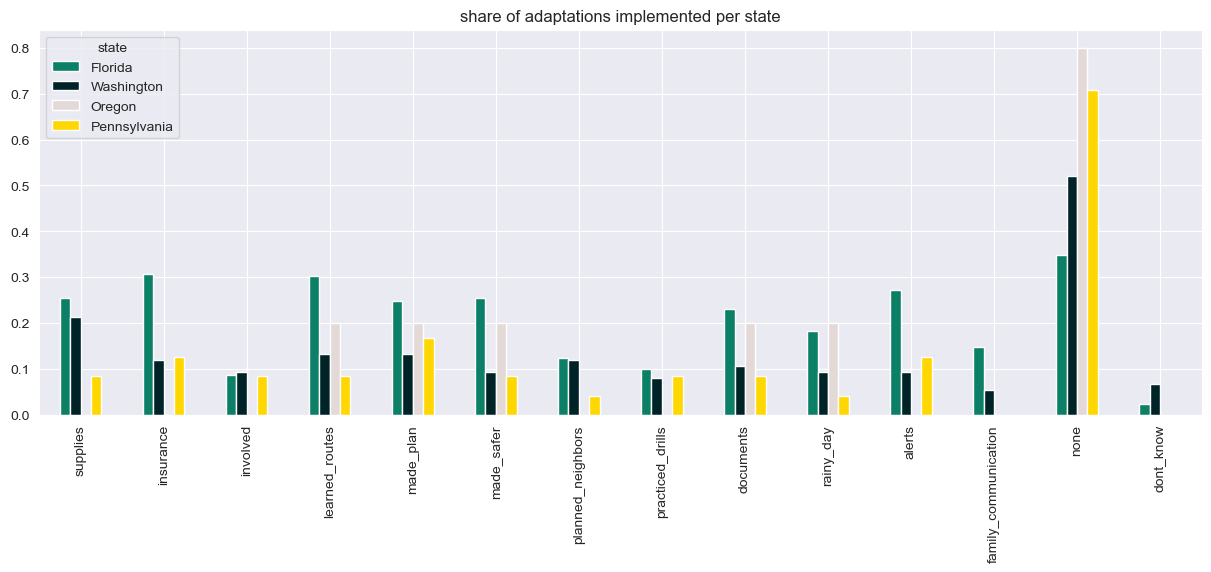

In [70]:
adaptations[['Florida', 'Washington', 'Oregon', 'Pennsylvania']].plot(
    kind='bar', 
    figsize=(15,5), 
    title='share of adaptations implemented per state',
    cmap=discrete)
plt.savefig('../figures/unimodal/adpataions_per_region_n.png',bbox_inches='tight', dpi=1000)

<span style = 'color:lightgreen'>
findings: 

- numbers might still be a bit skewed: FLorida and Washington are dispersed spatially more than New York

- Florida has generally higher share of adaptations implemented -> seperating equilibrium? 

<span style = 'color:orange'> Let's look into candidates for independent variables

In [72]:
independent = gdf.groupby('state').agg(
    experience = ('experience', 'mean'),
    ).transpose()

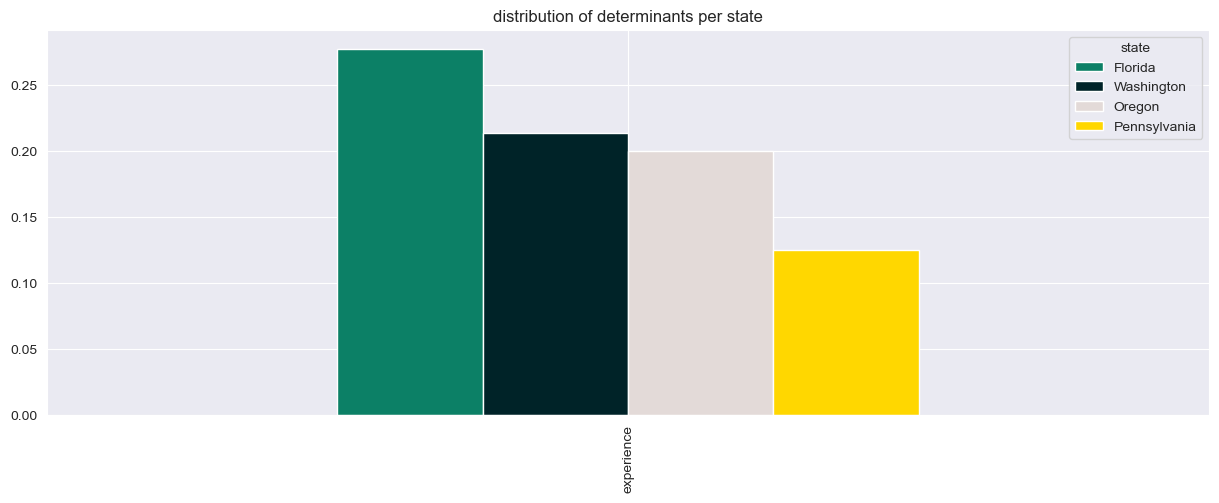

In [75]:
independent[['Florida', 'Washington', 'Oregon', 'Pennsylvania']].plot(
    kind='bar', 
    figsize=(15,5), 
    title='distribution of determinants per state',
    cmap=discrete)
plt.savefig('../figures/unimodal/determinants_per_region_n.png', dpi=1000)

<span style = 'color:orange'> Let's drill down into focus regions. This will allow us to investigate possible spatial interactions

In [50]:
# let's build seperate frames for each focus region
seattle = gdf[(gdf.county == 'King')]

newyork = gdf[(gdf.county == 'Kings') | 
              (gdf.county == 'Hudson') |
              (gdf.county == 'Queens')]

jacksonville = gdf[(gdf.county == 'Duval')]

miami = gdf[(gdf.county == 'Broward') |
            (gdf.county == 'Miami-Dade') |
            (gdf.county == 'Palm Beach') | 
            (gdf.county == 'Martin')]

sarasota = gdf[(gdf.county == 'Sarasota') | 
               (gdf.county == 'Charlotte') | 
               (gdf.county == 'Lee') |
               (gdf.county == 'Pinellas') | 
               (gdf.county == 'Collier')]

# let's add a column that indicates the focus region 
seattle["focus_region"] = "Seattle"
newyork["focus_region"] = "New York"
jacksonville["focus_region"] = "Jacksonville"
miami["focus_region"] = "Miami"
sarasota["focus_region"] = "Sarasota"

# let's put all together 
focus_regions = pd.concat([seattle, newyork, jacksonville, miami, sarasota])

## <span style='color:seagreen'> Relationships <span>

In [51]:
# Let's explore correlations on the focus_region level. We hope for differences in correlations between focus regions
variables = [ 'perception', 'experience', 'supplies', 'insured', 'involved', 'learned_routes',
             'made_plan', 'made_safer', 'planned_neighbors', 'practiced_drills', 'documents', 'rainy_day', 'alerts', 'family_communication',
              'none', 'dont_know' ,'age', 'sex','education', 'homeownership', 'income', 'rentmortgage','rurality' ,'zip_count']

In [52]:
dependent = ['supplies', 'insured', 'involved', 'learned_routes', 'made_plan', 'made_safer', 'planned_neighbors', 
            'practiced_drills', 'documents', 'rainy_day', 'alerts', 'family_communication', 'none', 'dont_know']
independent = ['experience']
covariate = ['age', 'income', 'race', 'education', 'homeownership']

In [53]:
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(df[var], df[v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(df[var], df[v]) for v in covariate]

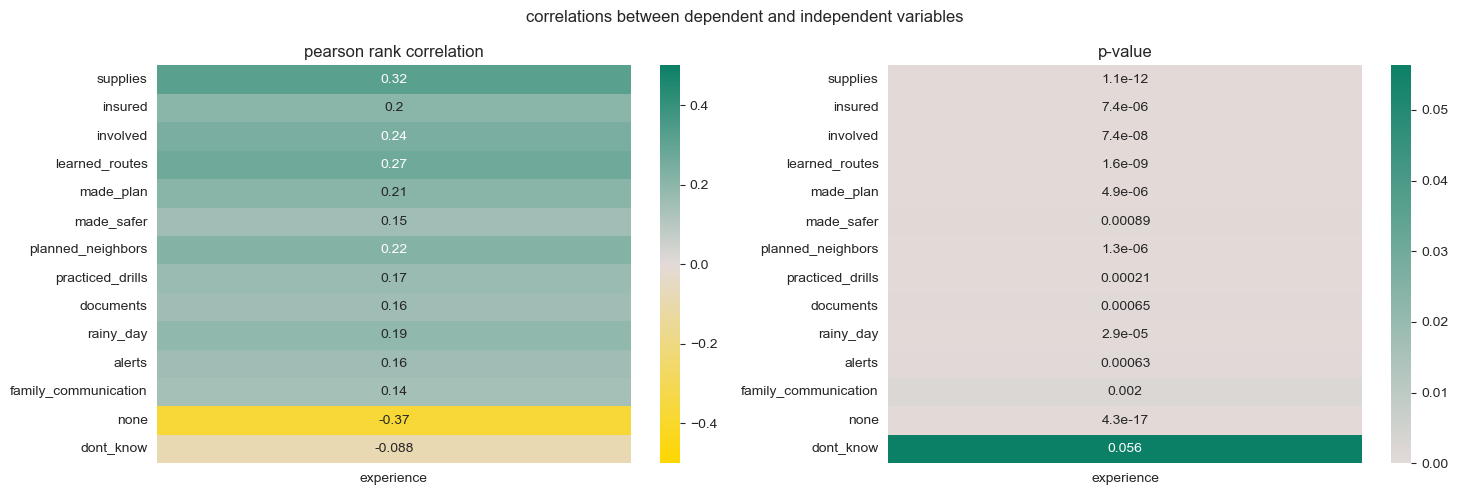

In [54]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) # access spearman r with lambda function
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap=sequential, annot=True) # access p-value with lambda function
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/full.png')

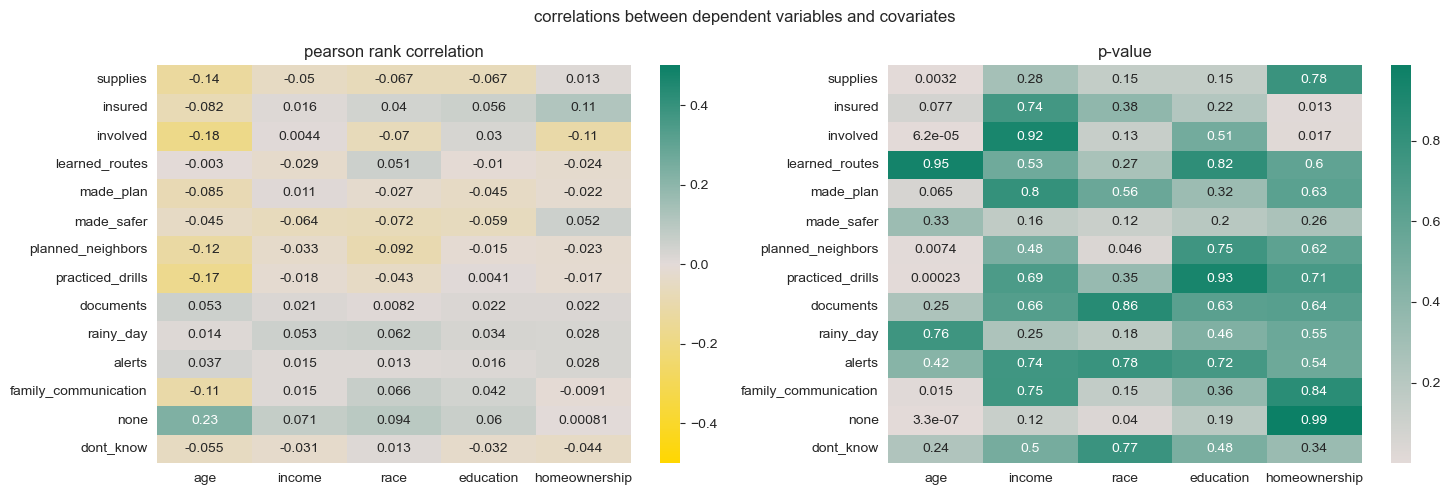

In [55]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_cov.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) # access spearman r with lambda function
sns.heatmap(data=dep_cov.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap=sequential, annot=True) # access p-value with lambda function
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('correlations between dependent variables and covariates')
plt.tight_layout()
plt.savefig('../figures/relations/covariates_full.png')

<span style= 'color:orange'> Let's compare correlations across focus regions

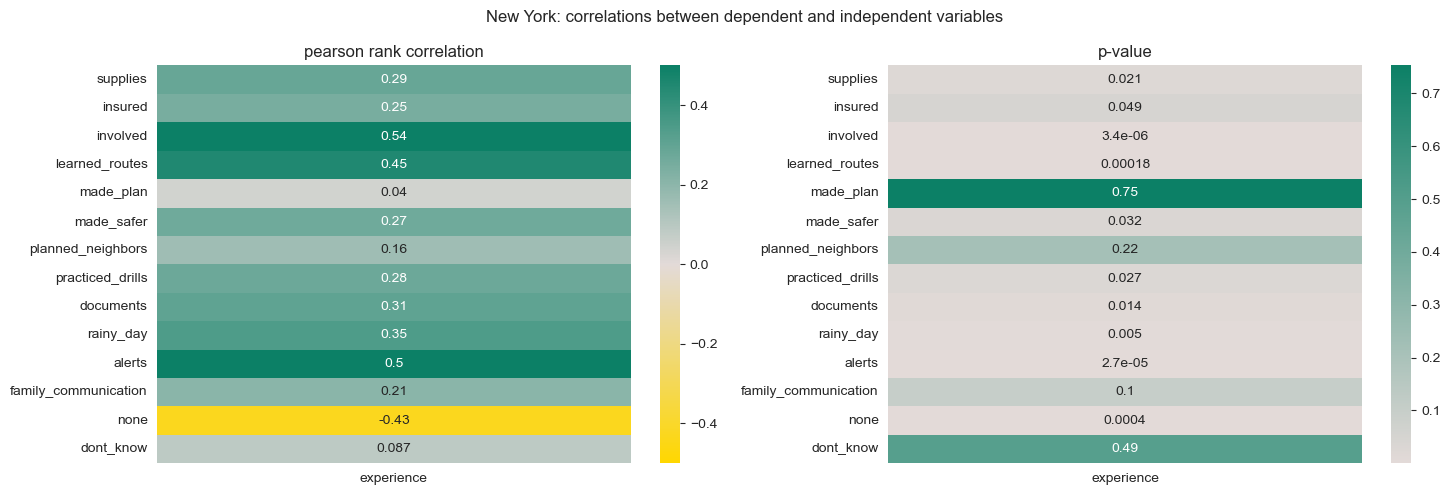

In [56]:
# New York
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(newyork[var], newyork[v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(newyork[var], newyork[v]) for v in covariate]

#plot
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) 
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap=sequential, annot=True) 
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('New York: correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/newyork.png')

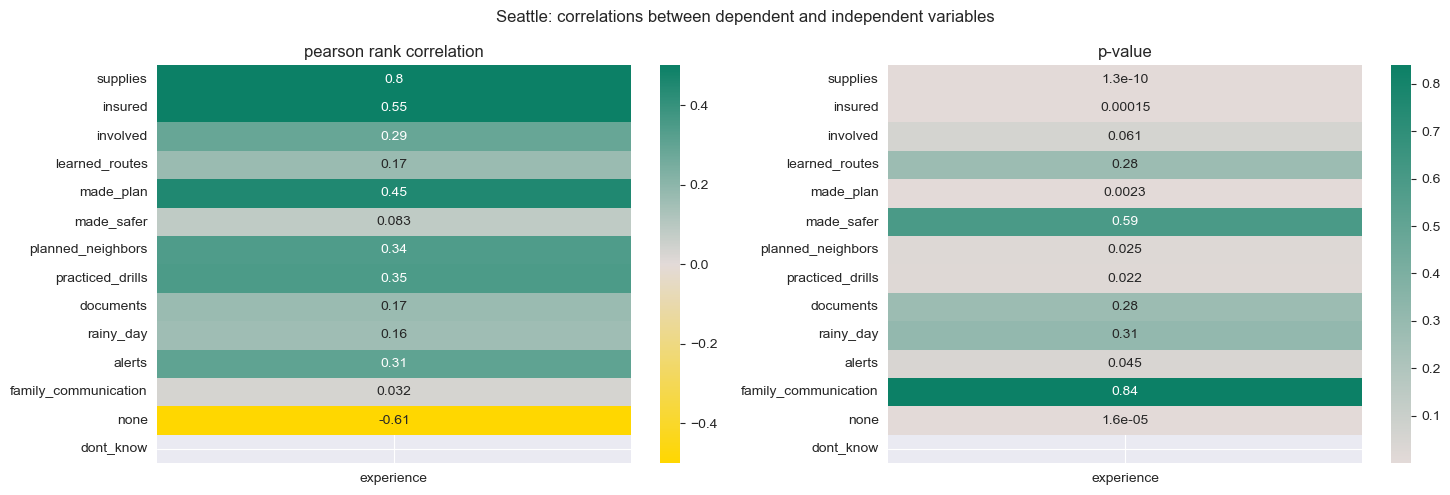

In [57]:
# Seattle
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(seattle[var], seattle[v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(seattle[var], seattle[v]) for v in covariate]

#plot
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) 
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap=sequential, annot=True) 
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('Seattle: correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/seattle.png')

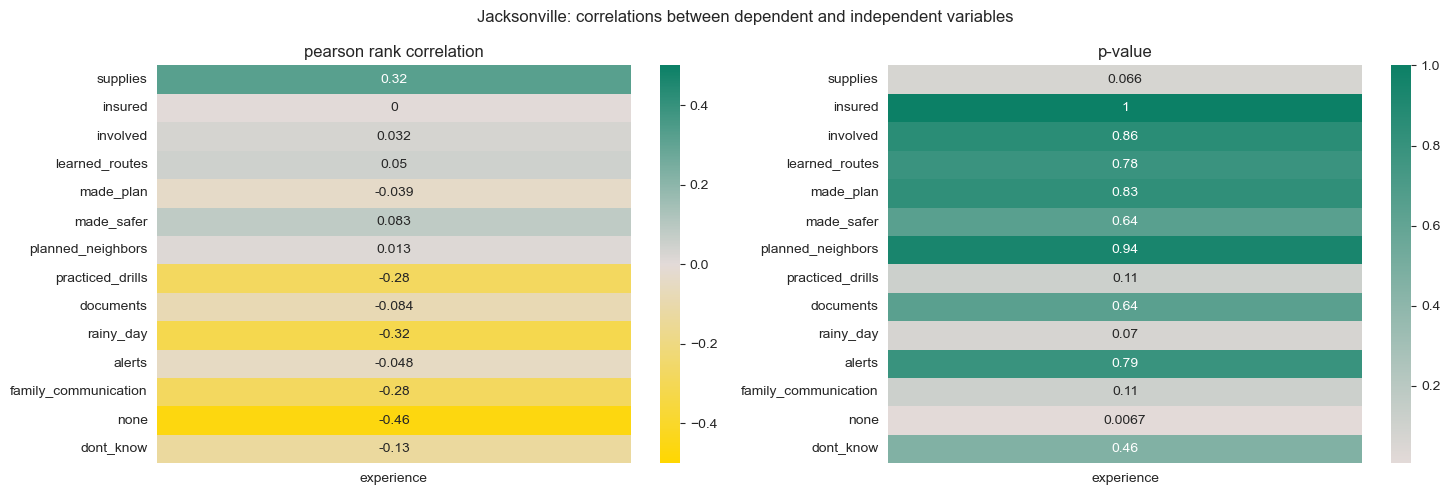

In [58]:
# Jacksonville
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(jacksonville[var], jacksonville[v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(jacksonville[var], jacksonville[v]) for v in covariate]

#plot
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) 
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap=sequential, annot=True) 
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('Jacksonville: correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/jacksonville.png')

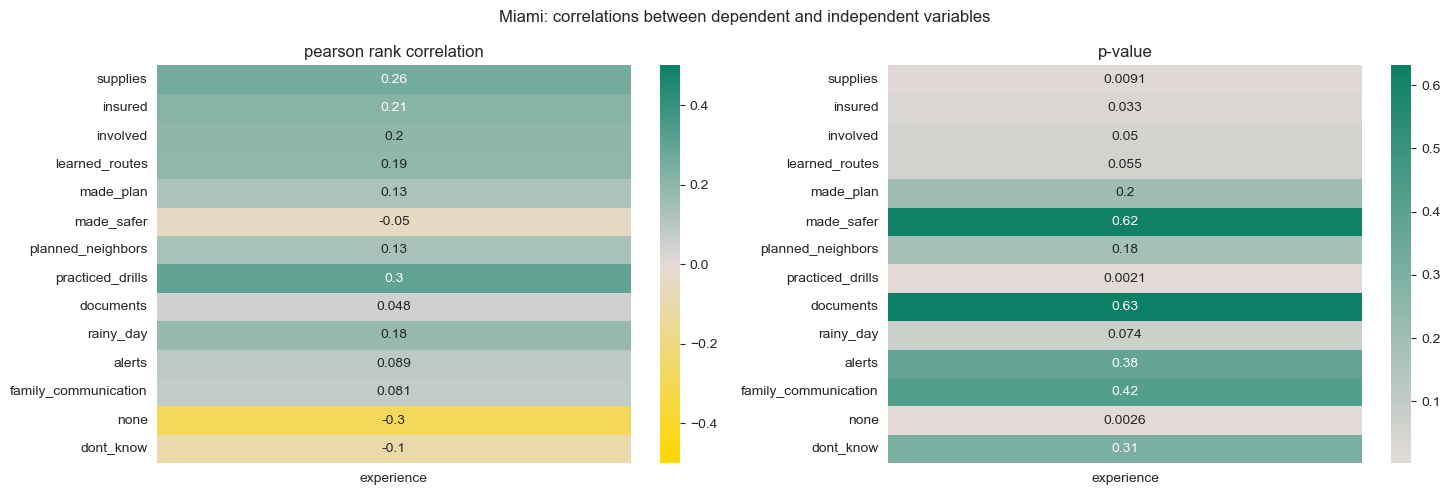

In [59]:
# Miami
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(miami[var], miami[v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(miami[var], miami[v]) for v in covariate]

#plot
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) 
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap=sequential, annot=True) 
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('Miami: correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/miami.png')

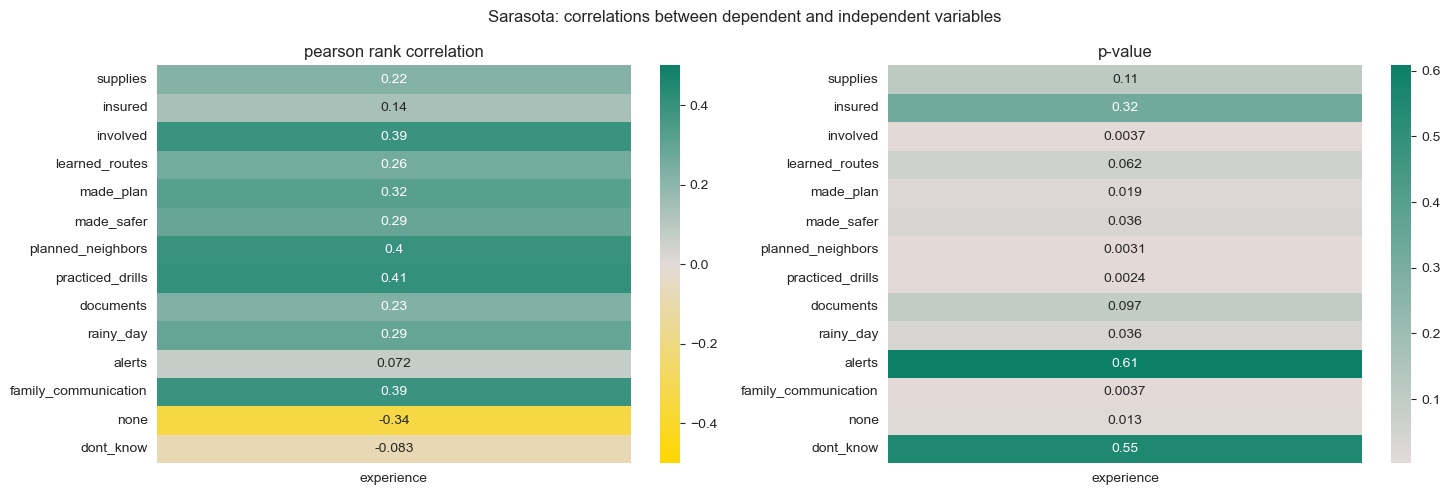

In [60]:
# Sarasota
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(sarasota[var], sarasota[v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(sarasota[var], sarasota[v]) for v in covariate]

#plot
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) 
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap=sequential, annot=True) 
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('Sarasota: correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/sarasota.png')

<span style = 'color: lightgreen'>

Adaptation Fatigue: 
- In Jacksonville experience seems to be much lower correlated with certain adaptaion variables than in York.
- Weaker effect but same effect direction in Miami. 
- We can hypothesize which variables are impacted by adaptaion fatigue and which are not 

<span style = 'color: orange'>

Let's check the hypothesis against larger regions (Florida v New York)


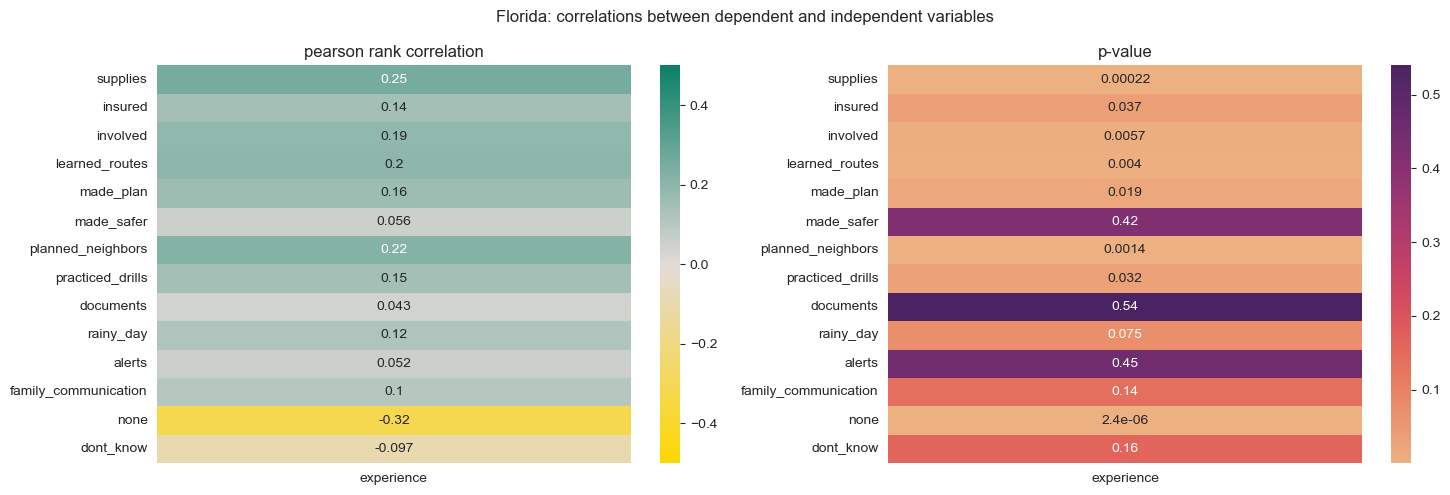

In [61]:
# Florida
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(df.loc[df['state'] == 'Florida',var], df.loc[df['state'] == 'Florida', v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(df.loc[df['state'] == 'Florida',var], df.loc[df['state'] == 'Florida', v]) for v in covariate]

#plot
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) 
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap='flare', annot=True) 
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('Florida: correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/florida.png')

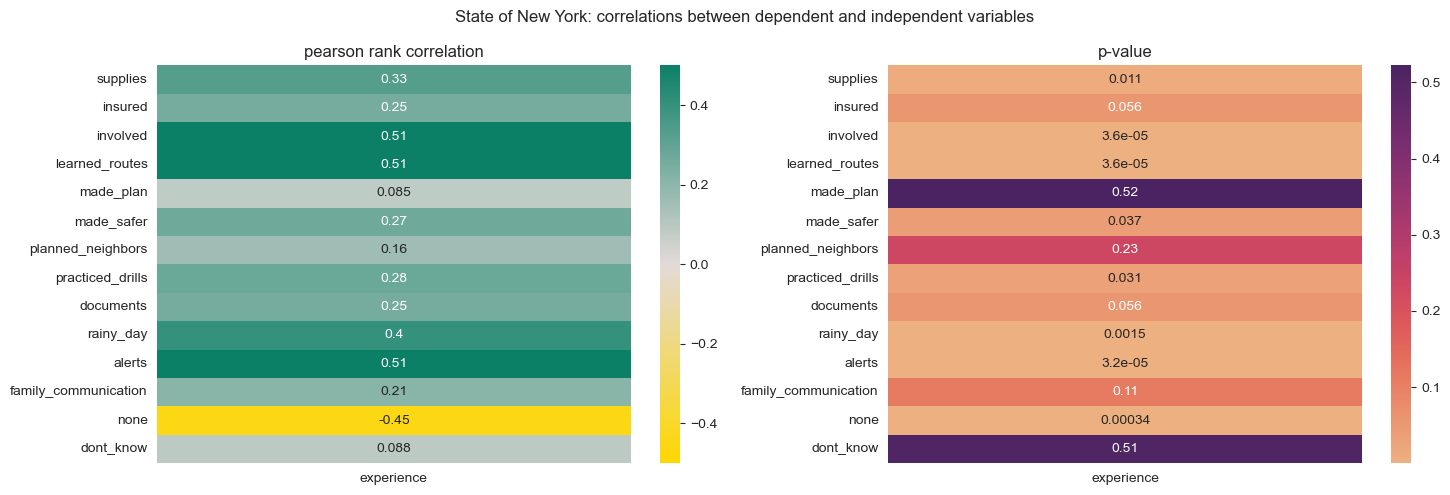

In [62]:
# Florida
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(df.loc[df['state'] == 'New York',var], df.loc[df['state'] == 'New York', v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(df.loc[df['state'] == 'New York',var], df.loc[df['state'] == 'New York', v]) for v in covariate]

#plot
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) 
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap='flare', annot=True) 
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('State of New York: correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/State_of_New_York.png')

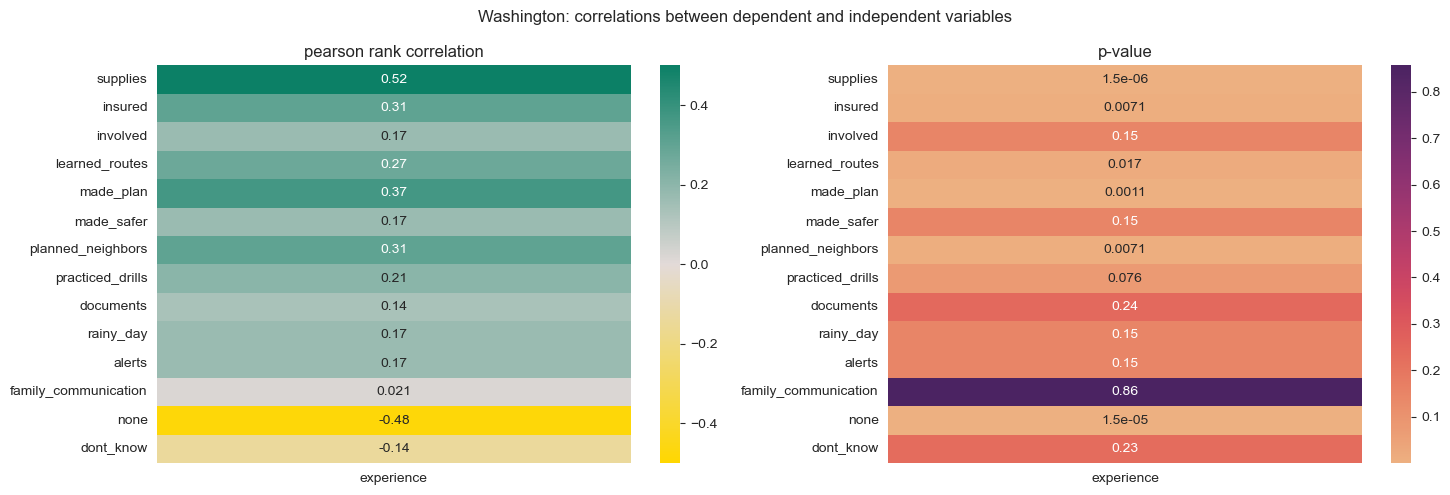

In [63]:
# Washington
dep_ind = pd.DataFrame(columns=dependent, index=independent)
dep_cov = pd.DataFrame(columns=dependent, index=covariate)
for idx, var in enumerate(dependent):
    dep_ind[var] = [stats.spearmanr(df.loc[df['state'] == 'Washington',var], df.loc[df['state'] == 'Washington', v]) for v in independent] #stats.spearman returns tuple(statistic, p-value)
    dep_cov[var] = [stats.spearmanr(df.loc[df['state'] == 'Washington',var], df.loc[df['state'] == 'Washington', v]) for v in covariate]

#plot
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data=dep_ind.applymap(lambda x: x[0]).transpose(), ax=ax[0], cmap=yellow_bright, vmin=-0.5, vmax=0.5, annot=True) 
sns.heatmap(data=dep_ind.applymap(lambda x: x[1]).transpose(), ax=ax[1], cmap='flare', annot=True) 
ax[0].set_title('pearson rank correlation')
ax[1].set_title('p-value')
plt.suptitle('Washington: correlations between dependent and independent variables')
plt.tight_layout()
plt.savefig('../figures/relations/Washington.png')

In [64]:
#Let's drill into zipcode level adaptation distribution per focus region 
florida_adaptations = gdf.groupby('zipcode').agg(
    supplies = ('supplies','sum'),
    insurance = ('insured','sum'),
    involved = ('involved','sum'),
    learned_routes = ('learned_routes','sum'),
    made_plan =  ('made_plan', 'sum'),
    made_safer = ('made_safer', 'sum'),
    planned_neighbors = ('planned_neighbors', 'sum'),
    practiced_drills = ('practiced_drills', 'sum'),
    documents = ('documents', 'sum'),
    rainy_day = ('rainy_day', 'sum'),
    alerts = ('alerts', 'sum'),
    family_communication = ('family_communication', 'sum'),
    none = ('none', 'sum'),
    dont_know = ('dont_know', 'sum')
)

In [65]:
newjersey_adaptations = gdf.groupby('zipcode').agg(
    supplies = ('supplies','sum'),
    insurance = ('insured','sum'),
    involved = ('involved','sum'),
    learned_routes = ('learned_routes','sum'),
    made_plan =  ('made_plan', 'sum'),
    made_safer = ('made_safer', 'sum'),
    planned_neighbors = ('planned_neighbors', 'sum'),
    practiced_drills = ('practiced_drills', 'sum'),
    documents = ('documents', 'sum'),
    rainy_day = ('rainy_day', 'sum'),
    alerts = ('alerts', 'sum'),
    family_communication = ('family_communication', 'sum'),
    none = ('none', 'sum'),
    dont_know = ('dont_know', 'sum')
)

In [66]:
Florida = df[df['state']=='Florida']
NewYork = df[df['state']=='New York']

In [67]:
Washington = df[df['state'] == 'Washington']
Washington.shape

(75, 30)

In [68]:
Florida.shape

(209, 30)

In [69]:
NewYork.shape

(59, 30)